In [1]:
import pandas as pd

path = "Absence report_20260120_1208.csv"
df = pd.read_csv(path)

print(df.shape)
print(df.columns.tolist())
df.head(3)


(922, 20)
['First name', 'Last name', 'Team names', 'Leave allowance', 'Leave entitlement', 'Entitlement unit', 'Absence type', 'Absence duration total in days', 'Absence duration for period in days', 'Absence description', 'Absence start date', 'Absence end date', 'Status reason', 'Absence status', 'Is ongoing', 'Fit note required', 'Estimated return date', 'Sickness start date type', 'Sickness end date type', 'Toil notes']


,First name,Last name,Team names,Leave allowance,Leave entitlement,Entitlement unit,Absence type,Absence duration total in days,Absence duration for period in days,Absence description,Absence start date,Absence end date,Status reason,Absence status,Is ongoing,Fit note required,Estimated return date,Sickness start date type,Sickness end date type,Toil notes
0,Stefanie,Lenehan,HR,NaN,20.0,days,Other,4.0,4.0,Pre-agreed WFH days,18 Jul 2025 00:00:00,23 Jul 2025 00:00:00,NaN,APPROVED,False,NaN,NaN,NaN,NaN,NaN
1,Stefanie,Lenehan,HR,NaN,20.0,days,Other,1.0,1.0,WFH,12 Sep 2025 00:00:00,12 Sep 2025 00:00:00,NaN,APPROVED,False,NaN,NaN,NaN,NaN,NaN
2,Stefanie,Lenehan,HR,NaN,20.0,days,Sickness,1.0,1.0,NaN,10 Apr 2025 00:00:00,10 Apr 2025 00:00:00,NaN,NaN,False,False,NaN,UNKNOWN,UNKNOWN,NaN


In [2]:
# convert to datetime (this is usually the key field)
df['Absence start date'] = pd.to_datetime(df['Absence start date'], errors='coerce')
df['Absence end date'] = pd.to_datetime(df['Absence end date'], errors='coerce')

print("Start date range:", df['Absence start date'].min(), "→", df['Absence start date'].max())
print("End date range:  ", df['Absence end date'].min(), "→", df['Absence end date'].max())

# check if we have any rows starting in Nov/Dec 2025
df['month'] = df['Absence start date'].dt.to_period('M').astype(str)

print("Rows in 2025-11:", (df['month'] == '2025-11').sum())
print("Rows in 2025-12:", (df['month'] == '2025-12').sum())


Start date range: 2024-12-23 00:00:00 → 2026-12-21 00:00:00
End date range:   2024-12-24 00:00:00 → 2026-12-24 00:00:00
Rows in 2025-11: 83
Rows in 2025-12: 136


In [3]:
# --------------------------------
# Step 2: Filter to Nov & Dec 2025
# --------------------------------

df['Absence start date'] = pd.to_datetime(df['Absence start date'], errors='coerce')
df['month'] = df['Absence start date'].dt.to_period('M').astype(str)

df_25 = df[df['month'].isin(['2025-11', '2025-12'])].copy()

# sanity check
df_25['month'].value_counts()


month
2025-12    136
2025-11     83
Name: count, dtype: int64

In [4]:
df_25[['Absence duration total in days',
       'Absence duration for period in days']].describe()


,Absence duration total in days,Absence duration for period in days
count,218.000000,219.000000
mean,1.377676,1.282344
std,1.475026,1.460511
min,0.000000,0.000000
25%,1.000000,0.500000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,15.000000,15.000000


In [8]:
# --------------------------------
# Step 3: Absence category mapping
# --------------------------------

def map_absence_type(x):
    x = str(x).lower()
    if 'annual' in x:
        return 'Annual Leave'
    elif 'sick' in x or 'medical' in x:
        return 'Medical + Sickness'
    elif 'wfh' in x or 'home' in x:
        return 'WFH'
    elif 'travel' in x:
        return 'Travel'
    else:
        return 'Other (excl. WFH, Travel)'

df_25['absence_category'] = df_25['Absence type'].apply(map_absence_type)

# sanity check
df_25['absence_category'].value_counts()


absence_category
Annual Leave                 114
Other (excl. WFH, Travel)     95
Medical + Sickness            10
Name: count, dtype: int64

In [9]:
# --------------------------------
# Step 4: KPI calculations
# --------------------------------

kpi_days = (
    df_25
    .groupby('month')['Absence duration for period in days']
    .sum()
)

nov_days = kpi_days.get('2025-11', 0)
dec_days = kpi_days.get('2025-12', 0)

diff_days = dec_days - nov_days
pct_change = (diff_days / nov_days * 100) if nov_days != 0 else 0

kpi_df = pd.DataFrame({
    'Metric': [
        'Total Absence Days',
        'Total Absence Days',
        'Difference (Dec - Nov)',
        '% Change'
    ],
    'Value': [
        round(nov_days, 1),
        round(dec_days, 1),
        round(diff_days, 1),
        f"{pct_change:.1f}%"
    ],
    'Period': [
        'Nov 2025',
        'Dec 2025',
        'Nov vs Dec',
        'Nov vs Dec'
    ]
})

kpi_df


,Metric,Value,Period
0,Total Absence Days,112.3,Nov 2025
1,Total Absence Days,168.6,Dec 2025
2,Difference (Dec - Nov),56.3,Nov vs Dec
3,% Change,50.1%,Nov vs Dec


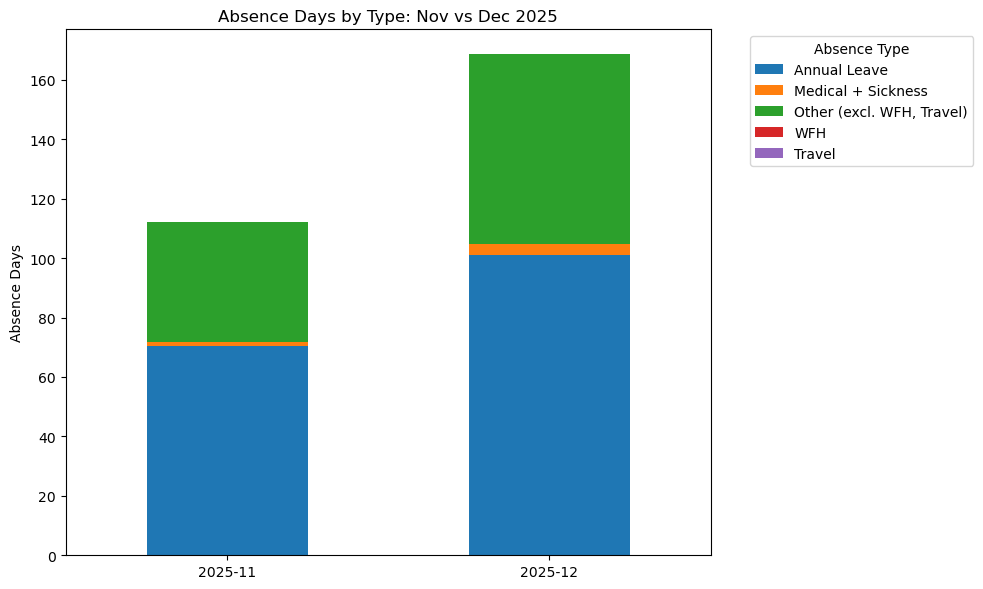

In [12]:
# --------------------------------
# Step 5: Absence by type (stacked)
# --------------------------------
import matplotlib.pyplot as plt

type_summary = (
    df_25
    .groupby(['month', 'absence_category'])['Absence duration for period in days']
    .sum()
    .unstack(fill_value=0)
)

order = [
    'Annual Leave',
    'Medical + Sickness',
    'Other (excl. WFH, Travel)',
    'WFH',
    'Travel'
]

type_summary = type_summary.reindex(columns=order, fill_value=0)

type_summary.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Absence Days by Type: Nov vs Dec 2025')
plt.ylabel('Absence Days')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(title='Absence Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


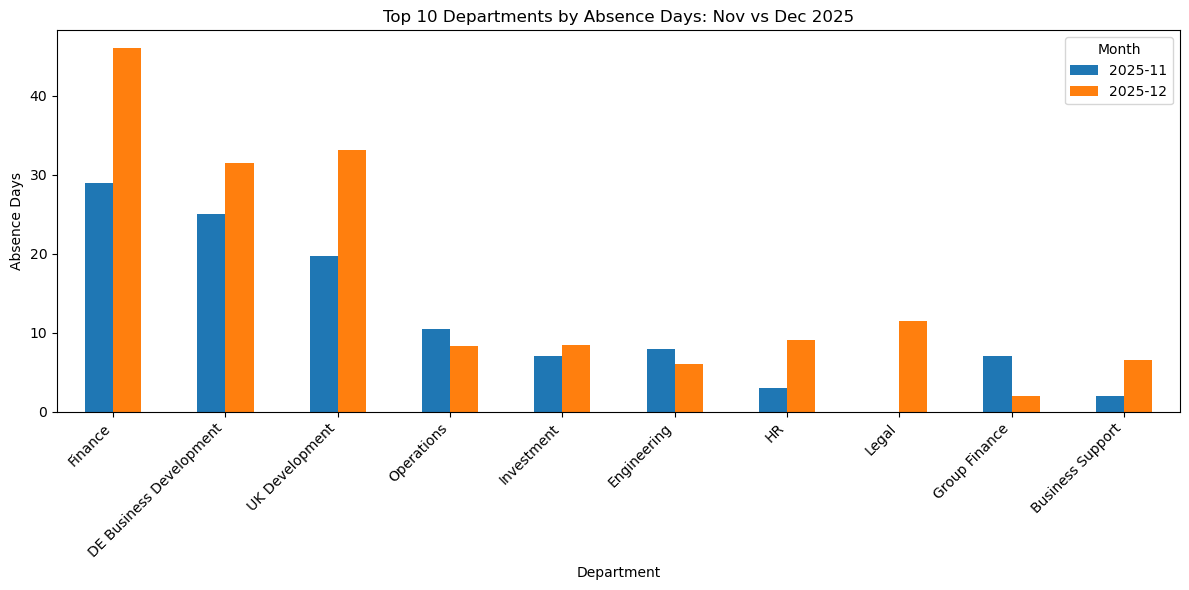

In [13]:
import matplotlib.pyplot as plt

# --------------------------------
# Step 6: Absence by Department (Nov vs Dec)
# --------------------------------

dept_summary = (
    df_25
    .groupby(['Team names', 'month'])['Absence duration for period in days']
    .sum()
    .reset_index()
)

# pivot for easier plotting
dept_pivot = dept_summary.pivot(index='Team names', columns='month', values='Absence duration for period in days').fillna(0)

# sort by total (Nov+Dec) and take top 10 for readability
dept_pivot['Total'] = dept_pivot.sum(axis=1)
dept_pivot = dept_pivot.sort_values('Total', ascending=False).drop(columns=['Total']).head(10)

dept_pivot.plot(kind='bar', figsize=(12, 6))

plt.title('Top 10 Departments by Absence Days: Nov vs Dec 2025')
plt.ylabel('Absence Days')
plt.xlabel('Department')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Month')
plt.tight_layout()
plt.show()


In [14]:
# --------------------------------
# Step 7: Individual drill-down table
# --------------------------------

individual_summary = (
    df_25
    .groupby(
        ['First name', 'Last name', 'Team names', 'month']
    )['Absence duration for period in days']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# ensure columns exist even if one month is missing
if '2025-11' not in individual_summary.columns:
    individual_summary['2025-11'] = 0
if '2025-12' not in individual_summary.columns:
    individual_summary['2025-12'] = 0

individual_summary['Difference (Dec - Nov)'] = (
    individual_summary['2025-12'] - individual_summary['2025-11']
)

# sort by absolute change (largest movers)
individual_summary = individual_summary.sort_values(
    'Difference (Dec - Nov)', ascending=False
)

individual_summary.head(10)


month,First name,Last name,Team names,2025-11,2025-12,Difference (Dec - Nov)
31,Rupal,Sutar,Finance,5.0,18.0000,13.0000
42,Verena,Stüwe,DE Business Development,0.5,9.5000,9.0000
16,Hyfa,Azeez,Legal,0.0,7.5000,7.5000
25,Mark,Wheeler,Investment,0.0,7.0000,7.0000
4,Charles,Jones,UK Development,2.0,8.5000,6.5000
28,Norman,Dressler,DE Business Development,0.0,6.5000,6.5000
38,Stefanie,Lenehan,HR,3.0,9.1333,6.1333
33,Selin,Bakare,Legal,0.0,4.0000,4.0000
17,Jae,Seung Lee,Property,0.0,3.5000,3.5000
10,Elena,Sarieva,UK Development,3.5,6.5000,3.0000


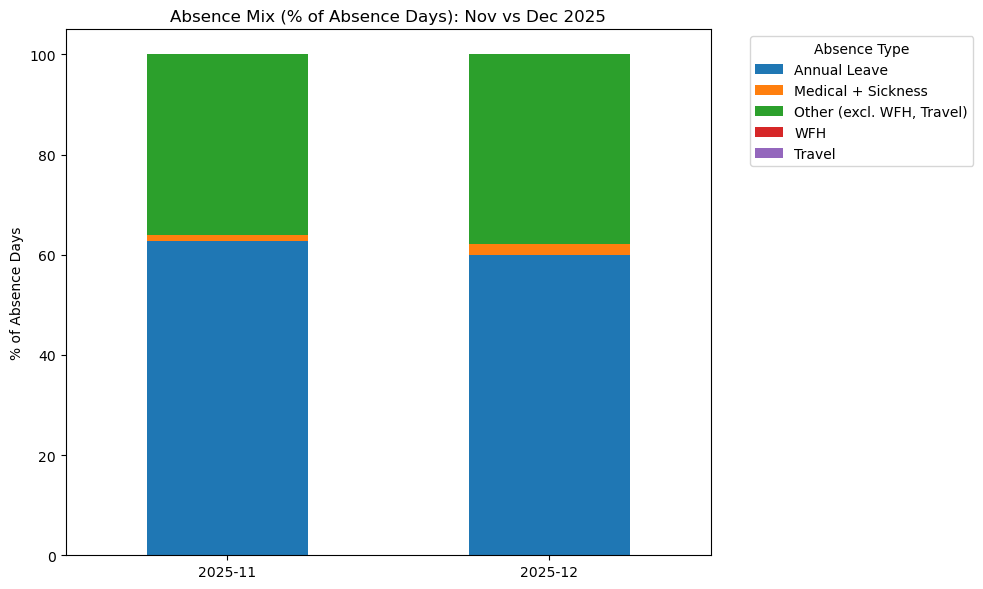

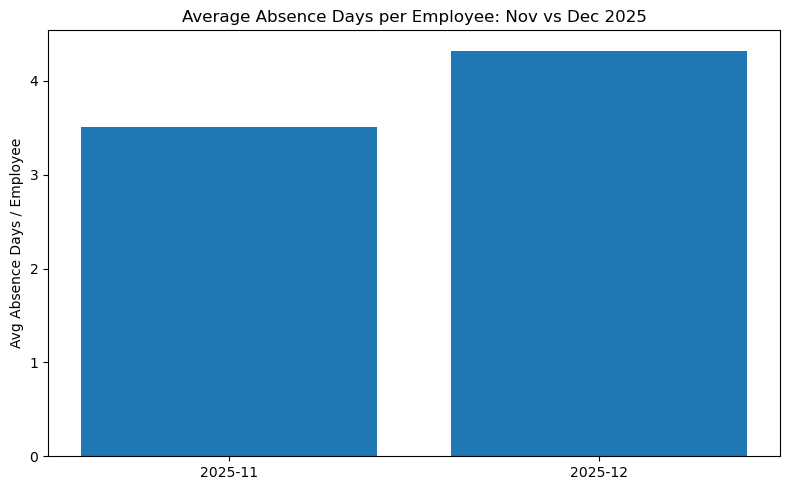

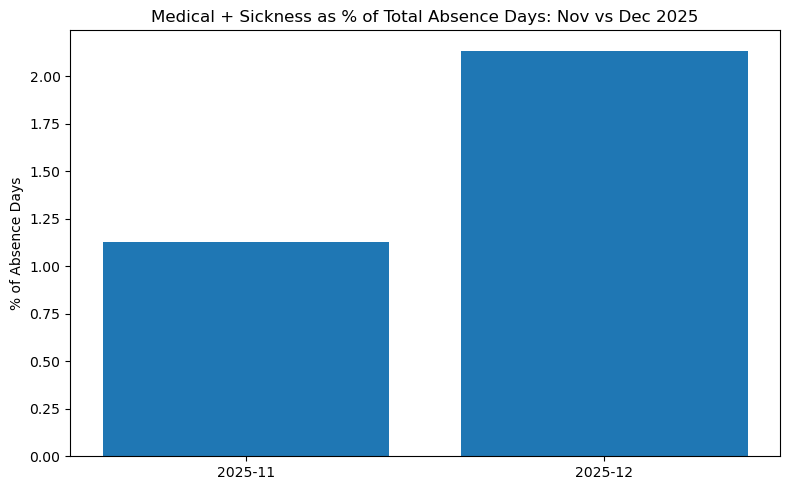

KPI (Nov vs Dec 2025)
2025-11 | Avg days/employee: 3.51 | Sickness share: 1.1%
2025-12 | Avg days/employee: 4.32 | Sickness share: 2.1%


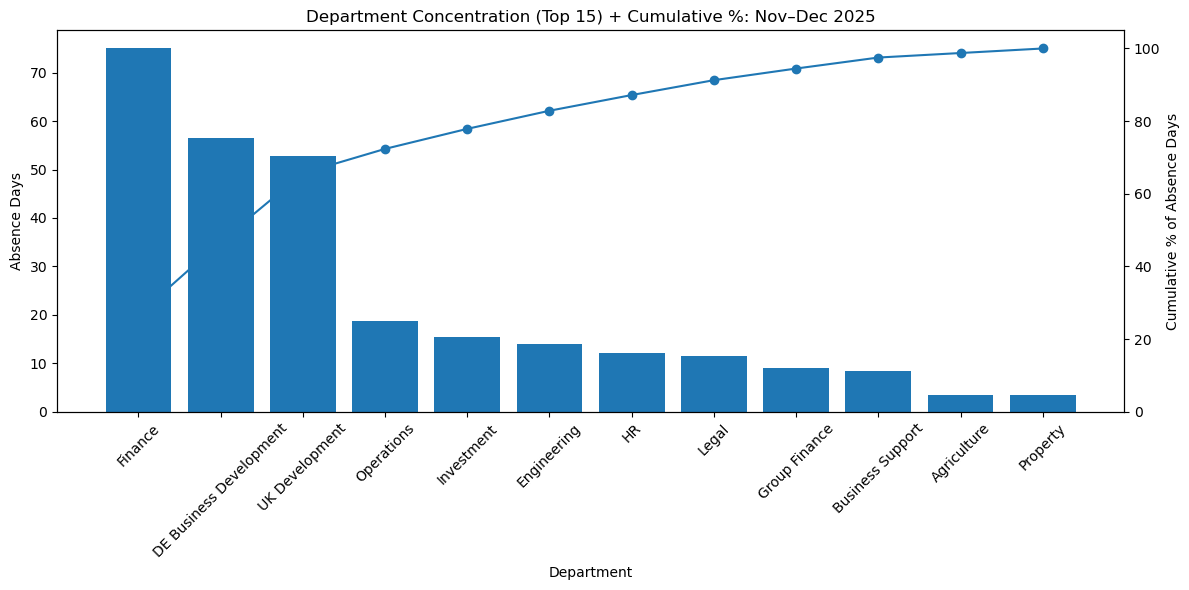

In [16]:
# =========================
# NEW VISUALISATIONS (Nov vs Dec 2025)
# Assumes df_25 exists with columns:
#   - month (string like '2025-11', '2025-12')
#   - absence_category (mapped buckets)
#   - Team names
#   - Absence duration for period in days
#   - First name, Last name (optional for headcount)
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- config ----------
METRIC_COL = 'Absence duration for period in days'
MONTHS = ['2025-11', '2025-12']
TYPE_ORDER = [
    'Annual Leave',
    'Medical + Sickness',
    'Other (excl. WFH, Travel)',
    'WFH',
    'Travel'
]

# ---------- helper: safe subset + ordering ----------
df_dash = df_25[df_25['month'].isin(MONTHS)].copy()

# ensure month is string for consistent plotting
df_dash['month'] = df_dash['month'].astype(str)

# ================
# 1) Absence Mix (%) — 100% stacked bar
# ================
mix_days = (
    df_dash
    .groupby(['month', 'absence_category'])[METRIC_COL]
    .sum()
    .unstack(fill_value=0)
    .reindex(columns=TYPE_ORDER, fill_value=0)
    .reindex(index=MONTHS, fill_value=0)
)

mix_pct = mix_days.div(mix_days.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100

ax = mix_pct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Absence Mix (% of Absence Days): Nov vs Dec 2025')
plt.ylabel('% of Absence Days')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(title='Absence Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# ================
# 2) Avg absence days per employee — KPI-style bar
#    (uses unique people in that month as denominator)
# ================
# unique employee key
df_dash['employee'] = (
    df_dash['First name'].astype(str).str.strip() + ' ' + df_dash['Last name'].astype(str).str.strip()
).str.strip()

monthly_days = df_dash.groupby('month')[METRIC_COL].sum().reindex(MONTHS).fillna(0)
monthly_emps = df_dash.groupby('month')['employee'].nunique().reindex(MONTHS).fillna(0)

avg_days_per_emp = (monthly_days / monthly_emps.replace(0, np.nan)).fillna(0)

plt.figure(figsize=(8, 5))
plt.bar(avg_days_per_emp.index, avg_days_per_emp.values)
plt.title('Average Absence Days per Employee: Nov vs Dec 2025')
plt.ylabel('Avg Absence Days / Employee')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ================
# 3) Sickness share (%) — KPI tile-style + simple bar
#    (Medical + Sickness as % of total absence days)
# ================
sick_days = (
    df_dash[df_dash['absence_category'] == 'Medical + Sickness']
    .groupby('month')[METRIC_COL]
    .sum()
    .reindex(MONTHS)
    .fillna(0)
)

total_days = monthly_days
sick_share = (sick_days / total_days.replace(0, np.nan)).fillna(0) * 100

plt.figure(figsize=(8, 5))
plt.bar(sick_share.index, sick_share.values)
plt.title('Medical + Sickness as % of Total Absence Days: Nov vs Dec 2025')
plt.ylabel('% of Absence Days')
plt.xlabel('')
plt.tight_layout()
plt.show()

# (optional) print KPI numbers neatly
print("KPI (Nov vs Dec 2025)")
for m in MONTHS:
    print(f"{m} | Avg days/employee: {avg_days_per_emp[m]:.2f} | Sickness share: {sick_share[m]:.1f}%")

# ================
# 4) Department concentration — Pareto-style bar + cumulative %
#    (Top 15 departments by total absence days across Nov+Dec)
# ================
dept_days = (
    df_dash
    .groupby('Team names')[METRIC_COL]
    .sum()
    .sort_values(ascending=False)
)

top_n = 15
dept_top = dept_days.head(top_n)

total = dept_top.sum()
total = np.nan if total == 0 else total

cum_pct = (dept_top.cumsum() / total) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(dept_top.index.astype(str), dept_top.values)
ax1.set_title(f'Department Concentration (Top {top_n}) + Cumulative %: Nov–Dec 2025')
ax1.set_ylabel('Absence Days')
ax1.set_xlabel('Department')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(dept_top.index.astype(str), cum_pct.values, marker='o')
ax2.set_ylabel('Cumulative % of Absence Days')
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.show()
